In [1]:
#Note: this notebook is like graph1, but it will specifically process particular tokens in the loss_per_token_scored.csv file

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
!echo $CONDA_DEFAULT_ENV

In [3]:
#paths
root_dir = "/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling"
group_folder = "repetition_final"
exp_name= ["pile1e8_10len", "pile1e8_20len", "pile1e8_40len", "pile1e8_80len"]
seed_name = ["seed0", "seed1", "seed2", "seed3", "seed4"]
model_sizes = ["70M"]
scored_file = "loss_per_token_scored.csv"

#these are the tokens that we will be averaging the losses to get our statistic
start_attend = 0
end_attend = 100

experiments = [f"{root_dir}/{group_folder}/{exp}_{seed}/{model_size}" for model_size in model_sizes for exp in exp_name for seed in seed_name]
experiments

['/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_10len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_10len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_10len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_10len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_10len_seed4/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_s

In [4]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
models

['1_model',
 '2_model',
 '4_model',
 '8_model',
 '16_model',
 '32_model',
 '64_model',
 '128_model',
 '256_model',
 '512_model',
 '1024_model']

In [5]:
def read_file(file_name):
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            row = [eval(element.strip()) for element in line.split(",")]
            data.append(row[start_attend:end_attend])
    return data

In [6]:
experiments_dfs = []
for experiment in experiments:
    model_dfs = []
    for model_type in models:
        model_dfs += [read_file(os.path.join(experiment,  model_type, scored_file))]
    experiments_dfs.append(model_dfs)
print(len(experiments_dfs))
print(len(model_dfs))

20
11


In [7]:

y_axises = []
null_means = []
null_stdev = []
statistic_total = []
for experiment_dfs in experiments_dfs:
    y_axis = []
    null_raw = []
    null_std = []
    statistic_temp = []
    for model_df in experiment_dfs:
        null_raw = model_df[1:]
        #we first average over tokens to get average loss per each example
        null = [statistics.mean(row) for row in null_raw]

        #we then calculate the average and stdev of this null distribution
        mean = statistics.mean(null)
        stdev = statistics.stdev(null)

        statistic = statistics.mean(model_df[0])
        # print(f"statistic = {statistic}, mean = {mean}, stdev = {stdev}")

        statistic_temp += [statistic]

        y_axis += [(statistic - mean) / stdev]
        null_means += [mean]
        null_std += [stdev]
    y_axises.append(y_axis)
    statistic_total.append(statistic_temp)
    null_stdev.append(null_std)

11


In [16]:
#reshape all the results into (length, seed, repetitions) format
def reshape_input(arr):
    arr = np.array(arr)
    arr = arr.reshape(len(exp_name), len(seed_name), -1)
    return arr

new_y_axises = reshape_input(y_axises)
new_null_means = reshape_input(null_means)
new_null_stdev = reshape_input(null_stdev)
new_statistic_total = reshape_input(statistic_total)

In [18]:
plot_values = new_y_axises.mean(axis=1)
plot_values

array([[ -0.17275651,  -0.31176224,  -0.65836967,  -0.80709802,
         -0.93975798,  -1.67211353,  -3.11868181,  -4.23873274,
         -4.85152544,  -5.74777021,  -5.81017869],
       [  0.18273629,  -0.05305495,  -0.49796719,  -0.90299613,
         -2.39077403,  -4.35338129,  -5.73971812,  -7.3416916 ,
         -7.58963441,  -8.03420778,  -8.42681689],
       [  0.64106006,   0.09179097,   0.13163651,  -1.16068285,
         -4.13373025,  -7.23268022, -10.17572179, -11.96858939,
        -12.40845421, -12.45239418, -12.84000864],
       [ -0.10543144,  -0.11026214,  -0.91974372,  -2.40377514,
         -5.20099389, -10.22424851, -15.59644819, -17.61122484,
        -18.05682599, -19.22024582, -18.7142962 ]])

In [17]:
x_axis = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
print(x_axis)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


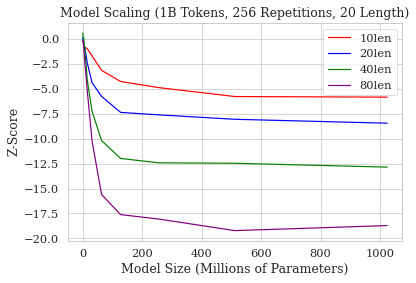

In [20]:
# Create a line plot for each set of y-values
sns.lineplot(x=x_axis, y=plot_values[0], color='red', label="10len")
sns.lineplot(x=x_axis, y=plot_values[1], color='blue', label="20len")
sns.lineplot(x=x_axis, y=plot_values[2], color='green', label="40len")
sns.lineplot(x=x_axis, y=plot_values[3], color='purple', label="80len")


# Customize the plot
plt.title('Model Scaling (1B Tokens, 256 Repetitions, 20 Length)')
plt.xlabel('Model Size (Millions of Parameters)')
plt.ylabel('Z-Score')
plt.legend()

# Show the plot
plt.show()

In [24]:
null_mean_values = new_null_means.mean(axis=1)
null_stdev_values = new_null_stdev.mean(axis=1)
statistic_values = new_statistic_total.mean(axis=1)


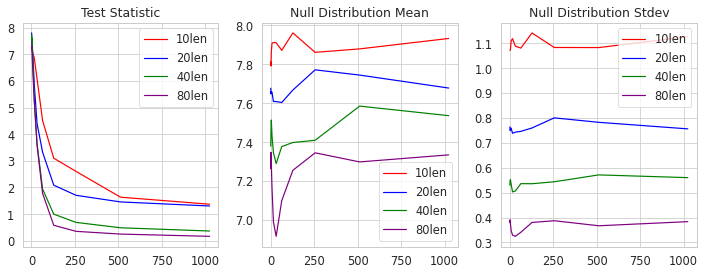

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.lineplot(x=x_axis, y=statistic_values[0], color='red', label="10len")
sns.lineplot(x=x_axis, y=statistic_values[1], color='blue', label="20len")
sns.lineplot(x=x_axis, y=statistic_values[2], color='green', label="40len")
sns.lineplot(x=x_axis, y=statistic_values[3], color='purple', label="80len")
plt.title('Test Statistic')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, 1st subplot
sns.lineplot(x=x_axis, y=null_mean_values[0], color='red', label="10len")
sns.lineplot(x=x_axis, y=null_mean_values[1], color='blue', label="20len")
sns.lineplot(x=x_axis, y=null_mean_values[2], color='green', label="40len")
sns.lineplot(x=x_axis, y=null_mean_values[3], color='purple', label="80len")
plt.title('Null Distribution Mean')

# Creating the second plot (Bar plot)
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.lineplot(x=x_axis, y=null_stdev_values[0], color='red', label="10len")
sns.lineplot(x=x_axis, y=null_stdev_values[1], color='blue', label="20len")
sns.lineplot(x=x_axis, y=null_stdev_values[2], color='green', label="40len")
sns.lineplot(x=x_axis, y=null_stdev_values[3], color='purple', label="80len")
plt.title('Null Distribution Stdev')

plt.tight_layout()
plt.show()